# Decision Tree Model 
Developing a Decision Tree model to predict early readmission of the patient within 30 days of discharge.

## Data Preparation

In [14]:
import pandas as pd
import numpy as np
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

dt_df = pd.read_csv('../data/diabetic_data_cleaned.csv')

### Changing 'readmitted' (target) to be binary (done after initial models were created)

In [15]:
#dt_df['readmitted'] = dt_df['readmitted'].apply(lambda x: 1 if x in ['<30', '>30'] else 0)
dt_df['readmitted'] = dt_df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [16]:
dt_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
1,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,0
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,0
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,0
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,0


In [17]:
dt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98053 entries, 0 to 98052
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              98053 non-null  int64 
 1   patient_nbr               98053 non-null  int64 
 2   race                      98053 non-null  object
 3   gender                    98053 non-null  object
 4   age                       98053 non-null  object
 5   admission_type_id         98053 non-null  int64 
 6   discharge_disposition_id  98053 non-null  int64 
 7   admission_source_id       98053 non-null  int64 
 8   time_in_hospital          98053 non-null  int64 
 9   num_lab_procedures        98053 non-null  int64 
 10  num_procedures            98053 non-null  int64 
 11  num_medications           98053 non-null  int64 
 12  number_outpatient         98053 non-null  int64 
 13  number_emergency          98053 non-null  int64 
 14  number_inpatient      

## Decision Tree Preprocessing

In [18]:
# define features and target
features = dt_df.drop(columns=['readmitted'], axis=1)
target = dt_df['readmitted']

# encode categorical varibles
categorical_cols = features.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    le = LabelEncoder()
    for col in categorical_cols:
        features[col] = le.fit_transform(features[col])

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 78442 samples
Testing set size: 19611 samples


## Decision Tree Model 1 Development

In [19]:
# intialize and train decision tree classifier
dt_classifier1 = DecisionTreeClassifier(criterion='entropy', max_depth=100, random_state=42)
dt_classifier1.fit(X_train, y_train)

# make predictions on training and testing sets
ytr_pred = dt_classifier1.predict(X_test)
yte_pred = dt_classifier1.predict(X_train)

# calculate accuracy
train_accuracy = accuracy_score(y_train, yte_pred)
test_accuracy = accuracy_score(y_test, ytr_pred)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")

Training accuracy: 1.0000
Testing accuracy: 0.8066


## Decision Tree Model 2
Model 1 has issues of overfitting, so I will try varying max_depth and min_samples_leaf to find the best model.

### Varying max_depth

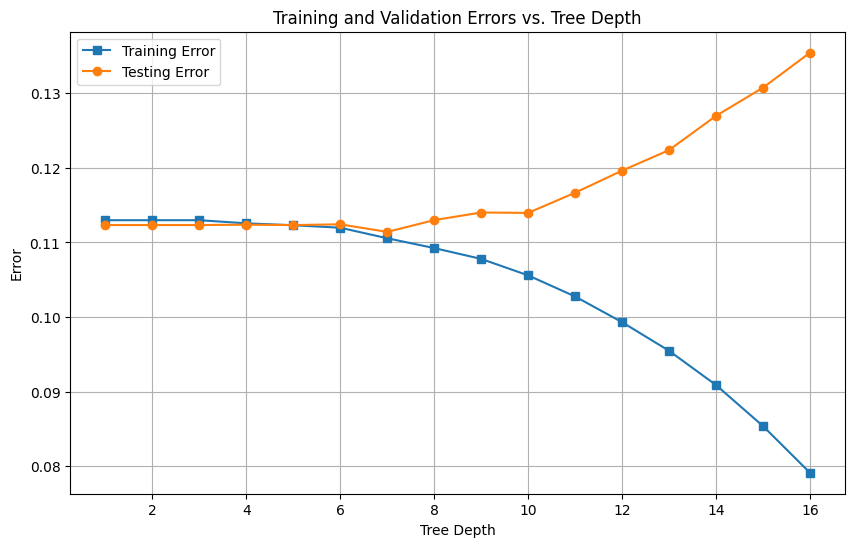

In [20]:
def vary_depth(X_train, X_test, y_train, y_test, size = 17): 
    depth_vals = range(1, size)
    train_errors = []
    test_errors = []

    for depth in depth_vals:
        dt_classifier2 = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
        dt_classifier2.fit(X_train, y_train)

        # predict training and test errors
        ytr_pred = dt_classifier2.predict(X_train)
        yte_pred = dt_classifier2.predict(X_test)

        # calculate training and test errors
        train_error = np.mean(ytr_pred != y_train)
        test_error = np.mean(yte_pred != y_test)

        # append errors to lists
        train_errors.append(train_error)
        test_errors.append(test_error)

    # plot training and test errors
    plt.figure(figsize=(10, 6))
    plt.plot(depth_vals, train_errors, marker='s', label = 'Training Error')
    plt.plot(depth_vals, test_errors, marker = 'o', label = 'Testing Error')
    plt.xlabel('Tree Depth')
    plt.ylabel('Error')
    plt.title('Training and Validation Errors vs. Tree Depth')
    plt.legend()
    plt.grid(True)
    plt.show()
vary_depth(X_train, X_test, y_train, y_test)

### Varying min_samples_leaf

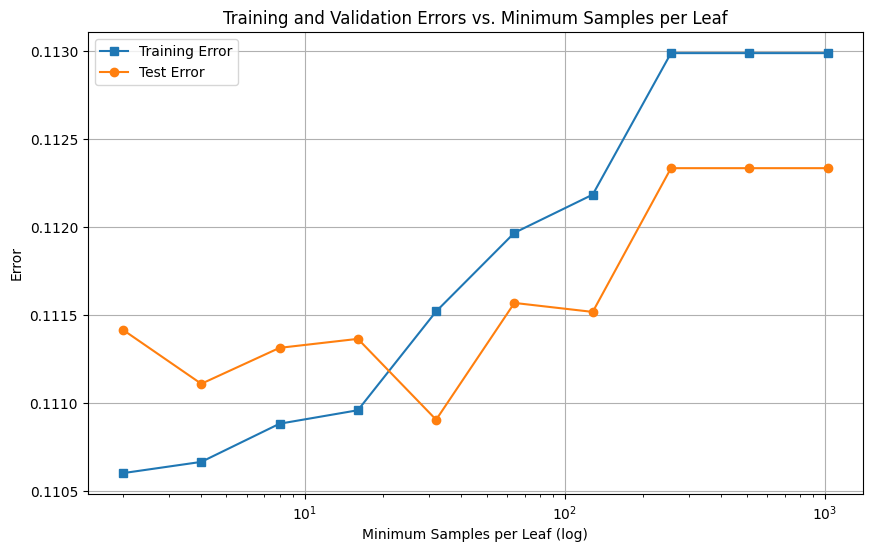

In [26]:
def vary_leaf_size(X_train, X_test, y_train, y_test):
    leaf_values = [2**i for i in range(1, 11)]
    train_errors = []
    test_errors = []
    for leaf in leaf_values:
        dt_classifier3 = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=leaf, random_state=42)
        dt_classifier3.fit(X_train, y_train)

        # predict training and test errors
        ytr_pred = dt_classifier3.predict(X_train)
        yte_pred = dt_classifier3.predict(X_test)

        # calculate training and test errors
        train_error = np.mean(ytr_pred != y_train)
        test_error = np.mean(yte_pred != y_test)

        # append errors to lists
        train_errors.append(train_error)
        test_errors.append(test_error)
        
    # plot training and test errors
    plt.figure(figsize=(10,6))
    plt.plot(leaf_values, train_errors, marker='s', label='Training Error')
    plt.plot(leaf_values, test_errors, marker='o', label='Test Error')
    plt.xscale('log')
    plt.xlabel('Minimum Samples per Leaf (log)')
    plt.ylabel('Error')
    plt.title('Training and Validation Errors vs. Minimum Samples per Leaf')
    plt.legend()
    plt.grid(True)
    plt.show()

vary_leaf_size(X_train, X_test, y_train, y_test)

### Model with chosen hyperparameter values
max_depth = 9 and min_samples_leaf = 100 give the lowest error rate fro the training data

In [28]:
# intialize and train decision tree classifier
dt_classifier2 = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=100, random_state=42)
dt_classifier2.fit(X_train, y_train)

# make predictions on training and testing sets
ytr_pred = dt_classifier2.predict(X_test)
yte_pred = dt_classifier2.predict(X_train)

# calculate accuracy
train_accuracy = accuracy_score(y_train, yte_pred)
test_accuracy = accuracy_score(y_test, ytr_pred)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")

Training accuracy: 0.8879
Testing accuracy: 0.8881


## More Feature Selection

### Picking top 10 important features

In [23]:
feature_importances = dt_classifier2.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_features = feature_importance_df.head(10)['Feature'].to_list()
X_train_filtered = X_train[top_features]
X_test_filtered = X_test[top_features]
print(feature_importance_df.head(20))

                     Feature  Importance
14          number_inpatient    0.361374
6   discharge_disposition_id    0.225387
1                patient_nbr    0.081215
0               encounter_id    0.059538
15                    diag_1    0.053096
17                    diag_3    0.035669
16                    diag_2    0.029646
18          number_diagnoses    0.021876
9         num_lab_procedures    0.021282
4                        age    0.020584
7        admission_source_id    0.012176
11           num_medications    0.011154
43               diabetesMed    0.009542
8           time_in_hospital    0.009260
13          number_emergency    0.008321
5          admission_type_id    0.007950
19                 metformin    0.006391
12         number_outpatient    0.006162
10            num_procedures    0.006003
36                   insulin    0.004761


### Filtering for those 10 features and the target: Resplitting and testing/training

In [29]:
target_filtered = target.loc[X_train_filtered.index]
# new split
X_trainf, X_testf, y_trainf, y_testf = train_test_split(X_train_filtered, target_filtered, test_size=0.2, random_state=42)

model4 = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=100,random_state=42)
model4.fit(X_trainf, y_trainf)
test_accuracy = model4.score(X_testf, y_testf)
train_accuracy = model4.score(X_trainf, y_trainf)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")
#vary_leaf_size(X_train, X_test, y_train, y_test)
#vary_depth(X_train, X_test, y_train, y_test)

Training accuracy: 0.8882
Testing accuracy: 0.8861


## Trying Ensemble Method: Random Forest with filtered features

In [30]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(X_train, X_test, y_train, y_test):
    # create random forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=7, min_samples_leaf=100,random_state=42)
    rf_classifier.fit(X_train, y_train)

    y_pred_rf = rf_classifier.predict(X_test)
    y_pred_train_rf = rf_classifier.predict(X_train)


    test_accuracy= accuracy_score(y_test, y_pred_rf)
    train_accuracy = accuracy_score(y_train, y_pred_train_rf)
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Testing accuracy: {test_accuracy:.4f}")

# use filtered features
random_forest(X_trainf, X_testf, y_trainf, y_testf)

Training accuracy: 0.8871
Testing accuracy: 0.8867
